In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
path = Path("UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [3]:
print(len(filenames))
print(filenames[:3])

23708
['26_0_2_20170104023102422.jpg.chip.jpg', '22_1_1_20170112233644761.jpg.chip.jpg', '21_1_3_20170105003215901.jpg.chip.jpg']


# Data preprocessing

Data I have downloaded is composed of 23,708 images with age and gender in the Image Name. For Example, 1_0_0_239389.JPG image means that age is 1, gender is 0 (male) and 0 refers to the race (not needed in this task).
So I split the image name on ' _ ' so I can get separated age and gender with image.
Also, I have shuffle all the images

In [4]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [5]:
#image_path

# From Unstructured data to Structured data

In [6]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

In [7]:
df.head()

,image,age,gender
0,39_0_1_20170113151528768.jpg.chip.jpg,39,0
1,51_0_0_20170111203742983.jpg.chip.jpg,51,0
2,34_0_1_20170116002253177.jpg.chip.jpg,34,0
3,15_1_2_20170104012024121.jpg.chip.jpg,15,1
4,22_1_0_20170116214345265.jpg.chip.jpg,22,1


In [8]:
gender_dict = {0:"Male",1:"Female"}

In [9]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [10]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


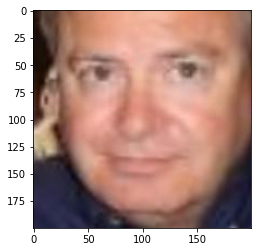

In [11]:
img = Image.open("UTKFace/"+df.image[1])
plt.imshow(img)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

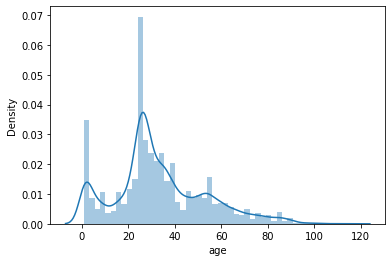

In [12]:
sns.distplot(df.age)

# Plotting Images

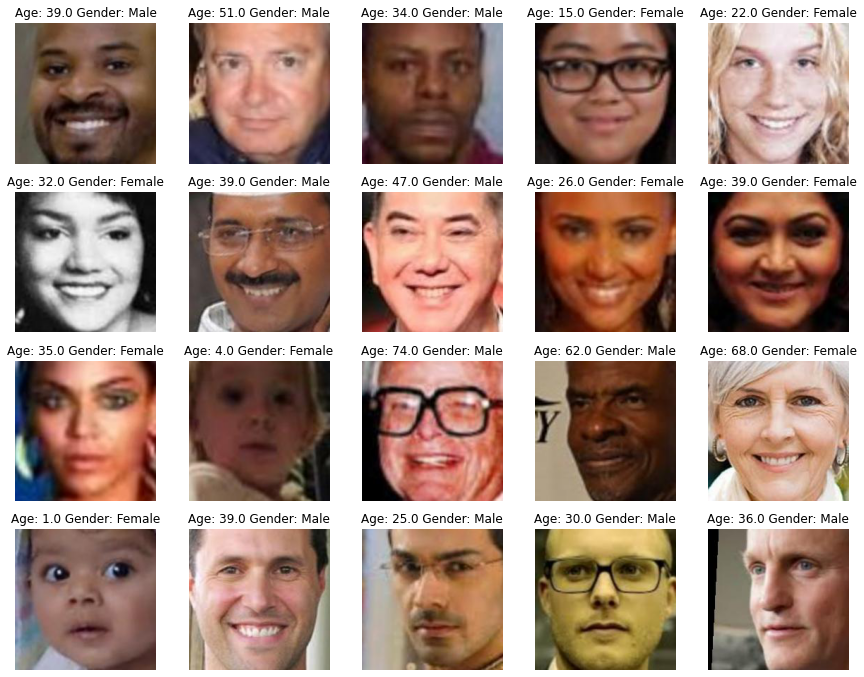

In [13]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/kaggle/input/utkface-new/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset. 
I have already shuffled all the data to ensure no biasness in the dataset.

In [14]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [15]:
train.head()

,image,age,gender
18199,67_0_0_20170109150725032.jpg.chip.jpg,67.0,0
19557,25_1_0_20170116002150531.jpg.chip.jpg,25.0,1
20132,63_0_0_20170111171747607.jpg.chip.jpg,63.0,0
11849,26_0_4_20170117200038821.jpg.chip.jpg,26.0,0
2100,32_0_1_20170113152015975.jpg.chip.jpg,32.0,0


# Extracting Features

In [16]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


In [17]:
x_train.shape

(3556, 128, 128, 1)

# Normalizing data

In [18]:
x_train = x_train/255

In [19]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [20]:
input_size = (128,128,1)

# Creating model

In [21]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [22]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 126, 126, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 42, 42, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Training the model

In [24]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=10, validation_split= 0.1)

Epoch 1/10
320/320 [==============================] - 12s 9ms/step - loss: 17.1241 - gender_output_loss: 0.6968 - age_output_loss: 16.4274 - gender_output_accuracy: 0.6559 - age_output_accuracy: 0.0512 - val_loss: 23.1140 - val_gender_output_loss: 0.6781 - val_age_output_loss: 22.4359 - val_gender_output_accuracy: 0.5225 - val_age_output_accuracy: 0.0730
Epoch 2/10
320/320 [==============================] - 3s 8ms/step - loss: 12.9285 - gender_output_loss: 0.5104 - age_output_loss: 12.4181 - gender_output_accuracy: 0.7559 - age_output_accuracy: 0.0466 - val_loss: 19.2048 - val_gender_output_loss: 0.4796 - val_age_output_loss: 18.7252 - val_gender_output_accuracy: 0.7865 - val_age_output_accuracy: 0.0618
Epoch 3/10
320/320 [==============================] - 3s 8ms/step - loss: 11.3493 - gender_output_loss: 0.4376 - age_output_loss: 10.9118 - gender_output_accuracy: 0.7991 - age_output_accuracy: 0.0484 - val_loss: 20.8270 - val_gender_output_loss: 0.4729 - val_age_output_loss: 20.3541 - 

# Visualizing loss

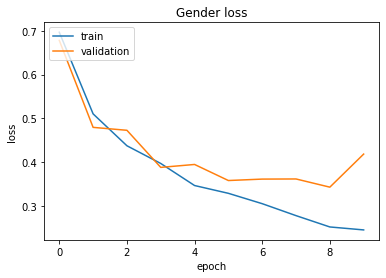

In [25]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

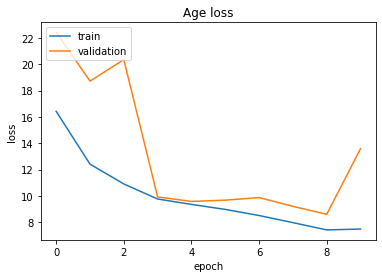

In [26]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test image

Original: Gender =  Male  Age =  75.0
Prediction: Gender =  Male  Age =  64


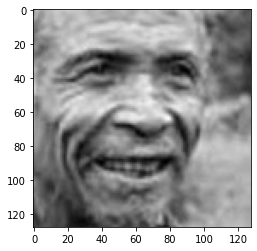

In [27]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Female  Age =  32.0
Prediction: Gender =  Female  Age =  30


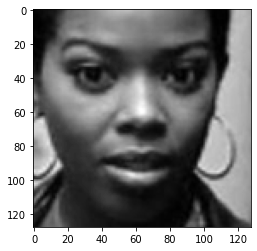

In [28]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

### RandomForest

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# # Normalize image data
# x_train = x_train / 255.0

# # Convert labels to numpy arrays
# y_gender = np.array(train.gender)  # Binary classification
# y_age = np.array(train.age)  # Regression problem

9420800/9406464 [==============================] - 0s 0us/step
Random Forest Gender Classification Accuracy: 75.84%
Random Forest Age Prediction MAE: 10.42
Original: Gender = Female Age = 75.0
Prediction: Gender = Female Age = 46


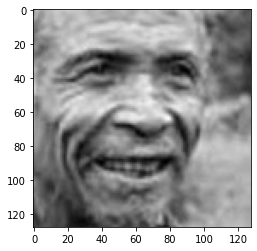

In [29]:


# feature extractor (MobileNetV2 as a feature extractor)
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
feature_extractor = Model(inputs=base_model.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))

features = feature_extractor.predict(np.repeat(x_train, 3, axis=-1))  # Convert grayscale to 3 channels

X_train, X_test, y_gender_train, y_gender_test, y_age_train, y_age_test = train_test_split(
    features, y_gender, y_age, test_size=0.1, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training Random Forest models
rf_gender = RandomForestClassifier(n_estimators=100, random_state=42)
rf_age = RandomForestRegressor(n_estimators=100, random_state=42)

rf_gender.fit(X_train, y_gender_train)
rf_age.fit(X_train, y_age_train)

# Evaluate models
gender_acc = rf_gender.score(X_test, y_gender_test)
age_mae = np.mean(abs(rf_age.predict(X_test) - y_age_test))

print(f"Random Forest Gender Classification Accuracy: {gender_acc * 100:.2f}%")
print(f"Random Forest Age Prediction MAE: {age_mae:.2f}")


In [ ]:
index = 50
original_gender = y_gender[index]
original_age = y_age[index]

pred_gender = rf_gender.predict([features[index]])[0]
pred_age = round(rf_age.predict([features[index]])[0])

gender_dict = {0: 'Female', 1: 'Male'}
print("Original: Gender =", gender_dict[original_gender], "Age =", original_age)
print("Prediction: Gender =", gender_dict[pred_gender], "Age =", pred_age)

plt.imshow(x_train[index].reshape(128, 128), cmap='gray')
plt.show()

In [ ]:
import joblib

joblib.dump(rf_gender, "rf_gender_model.pkl")
joblib.dump(rf_age, "rf_age_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Models and scaler saved successfully!")
